### 載入所需的Libraries

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from typing import List

### 載入資料

In [2]:
# read data from spam.csv

sms_data = pd.read_csv('spam.csv', encoding='utf-8',sep=',')
sms_data.columns = (['label','corpus','1','2','3'])
sms_data['corpus'] = sms_data['corpus']
sms_data.drop(columns=['1','2','3'])

,label,corpus
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will �_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [3]:
# check how many spams and hams
sms_data.groupby('label').count()

,corpus,1,2,3
label,,,,
ham,4825,45,10,6
spam,747,5,2,0


In [4]:
# change label to from string to number
# "ham" --> 0, "spam" --> 1
sms_data.drop(columns=['1','2','3'],inplace = True)
sms_data['label'] = sms_data['label'].apply(lambda x:0 if x=='ham' else 1)
###<your code>###


In [5]:
for i in range(len(sms_data)):
    sms_data.iloc[i,1] = sms_data.iloc[i,1].lower()
    sms_data

In [6]:
sms_data

,label,corpus
0,0,"go until jurong point, crazy.. available only ..."
1,0,ok lar... joking wif u oni...
2,1,free entry in 2 a wkly comp to win fa cup fina...
3,0,u dun say so early hor... u c already then say...
4,0,"nah i don't think he goes to usf, he lives aro..."
...,...,...
5567,1,this is the 2nd time we have tried 2 contact u...
5568,0,will �_ b going to esplanade fr home?
5569,0,"pity, * was in mood for that. so...any other s..."
5570,0,the guy did some bitching but i acted like i'd...


### 切分資料
將資料依據label比例切分為training data與testing data

In [7]:
###<your code>###
sms_train = sms_data.iloc[:round(0.8*len(sms_data)),:]
sms_test = sms_data.iloc[round(0.8*len(sms_data)):,:]
print(sms_train.groupby("label").count())
print(sms_test.groupby("label").count())

       corpus
label        
0        3856
1         602
       corpus
label        
0         969
1         145


### 資料預處理
* 將所有字詞轉為小寫
* 移除所有數字、標點符號

In [8]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    
    for i in range(len(df)):
        # make all content to lowercase
        content = df.iloc[i,1].lower()

        # remove all punctuations
        pattern = r'[A-Za-z]+'
        df.iloc[i,1]= " ".join([word for word in re.findall(pattern, content) if word != ""])
    
    return df

processed_train = preprocess(sms_train)
processed_test = preprocess(sms_test)

print("Train:")
print(processed_train.head())
print("Test:")
print(processed_test.head())

Train:
   label                                             corpus
0      0  go until jurong point crazy available only in ...
1      0                            ok lar joking wif u oni
2      1  free entry in a wkly comp to win fa cup final ...
3      0        u dun say so early hor u c already then say
4      0  nah i don t think he goes to usf he lives arou...
Test:
      label                                             corpus
4458      1  welcome to uk mobile date this msg is free giv...
4459      0  this is wishing you a great day moji told me a...
4460      0  thanks again for your reply today when is ur v...
4461      0  sorry i flaked last night shit s seriously goi...
4462      0  he said i look pretty wif long hair wat but i ...


In [9]:
# split data into x_train, y_train, x_test, y_test
y_train, x_train = zip(*processed_train.values)
y_test, x_test = zip(*processed_test.values)

# check numbers of unique word in the corpus
len(set(" ".join(list(x_train + x_test)).split()))

7708

### TF-IDF
可以發現種共有7708個字詞，這裡使用TF-IDF將來選取最高分的前2000個字詞
(若忘記的學員可參考先前TF-IDF課程章節或[此篇教學](https://ithelp.ithome.com.tw/articles/10228815?sc=iThelpR))

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
###<your code>###
vectorizer = TfidfVectorizer(max_features=2000)
vectorizer.fit(set(" ".join(list(x_train + x_test)).split()))
print(f"Number of unique word: {len(vectorizer.vocabulary_)}")
tfidf_train = vectorizer.transform(x_train)
tfidf_test = vectorizer.transform(x_test)
(tfidf_train, tfidf_test)

Number of unique word: 2000


(<4458x2000 sparse matrix of type '<class 'numpy.float64'>'
 	with 13629 stored elements in Compressed Sparse Row format>,
 <1114x2000 sparse matrix of type '<class 'numpy.float64'>'
 	with 3306 stored elements in Compressed Sparse Row format>)

### 建立共現矩陣

In [12]:
def create_co_matrix(corpus: List[str], vocab_list: List[str], word2idx: dict,
                     window_size: int=1, use_weighting: bool=False, verbose: bool=False) -> np.ndarray:
    '''Function to create co-occurrence matrix
    '''
    #initialize co-occurrence matrix
    co_matrix = np.zeros(shape=(len(vocab_list),len(vocab_list)), dtype=np.int32)
    
    for idx, sms in enumerate(corpus):
        sms_ids =[word2idx[i] for i in sms.split() if i in vocab_list]
    
        for center_i, center_word_id in enumerate(sms_ids):
            left_idx = idx - window_size if idx - window_size >= 0 else 0
            context_ids = sms[left_idx:idx]
            
            for left_i, left_word_id in enumerate(context_ids):
                co_matrix[center_word_id, left_idx] += 1
                co_matrix[left_idx, center_word_id] += 1

        if verbose:
            if idx != 0 and idx%500 == 0:
                    print(f"finishing {idx+1}/{len(corpus)}")
    print("Done")
    if use_weighting:
        np.fill_diagonal(co_matrix,1)
        
    return co_matrix

co_matrix = create_co_matrix(x_train, vectorizer.get_feature_names(), vectorizer.vocabulary_, window_size=3, use_weighting=True, verbose=True)

co_matrix

finishing 501/4458
finishing 1001/4458
finishing 1501/4458
finishing 2001/4458
finishing 2501/4458
finishing 3001/4458
finishing 3501/4458
finishing 4001/4458
Done


array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int32)

In [13]:
sum(sum(co_matrix))

4246

### 建立PPMI矩陣

In [14]:
a = np.array([[1,2,3],[4,5,6],[7,8,9]])
print(a)
a.sum(axis=1)

[[1 2 3]
 [4 5 6]
 [7 8 9]]


array([ 6, 15, 24])

In [15]:
#定義正向點間互資訊

def ppmi(co_matrix: np.ndarray, eps: float=1e-8, verbose: bool=False):
    n = np.sum(co_matrix)
    M = np.zeros_like(co_matrix, dtype=np.float32)
    px = co_matrix.sum(axis = 0)
    total = co_matrix.shape[0]*co_matrix.shape[1]
    cnt = 0
    
    for i in range(co_matrix.shape[0]):
        for j in range(co_matrix.shape[1]):
            pmi = np.log2(co_matrix[i,j] * n /(px[i] * px[j] + eps))
            M[i,j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt %100000 == 0 or cnt == total:
                    print(f"{cnt}/{total} Done")
    
    return M

ppmi_matrix = ppmi(co_matrix, verbose=True)
ppmi_matrix

100000/4000000 Done
200000/4000000 Done
300000/4000000 Done
400000/4000000 Done
500000/4000000 Done
600000/4000000 Done
700000/4000000 Done
800000/4000000 Done
900000/4000000 Done
1000000/4000000 Done
1100000/4000000 Done
1200000/4000000 Done
1300000/4000000 Done
1400000/4000000 Done
1500000/4000000 Done
1600000/4000000 Done
1700000/4000000 Done
1800000/4000000 Done
1900000/4000000 Done
2000000/4000000 Done
2100000/4000000 Done
2200000/4000000 Done
2300000/4000000 Done
2400000/4000000 Done
2500000/4000000 Done
2600000/4000000 Done
2700000/4000000 Done
2800000/4000000 Done
2900000/4000000 Done
3000000/4000000 Done
3100000/4000000 Done
3200000/4000000 Done
3300000/4000000 Done
3400000/4000000 Done
3500000/4000000 Done
3600000/4000000 Done
3700000/4000000 Done
3800000/4000000 Done
3900000/4000000 Done
4000000/4000000 Done


array([[ 3.2672539,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  8.051888 ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  3.5560336, ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [ 0.       ,  0.       ,  0.       , ..., 12.051888 ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       , 12.051888 ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
        12.051888 ]], dtype=float32)

### 使用SVD降維
利用sklearn中的TruncatedSVD對co-occurrence matrix進行降維，並利用variance來找出最適合的維度
[參考文獻](https://medium.com/swlh/truncated-singular-value-decomposition-svd-using-amazon-food-reviews-891d97af5d8d)

(讀者可以嘗試使用SVD對PPMI進行降維)

Number of components = 10 and explained variance = 0.3036463894164255
Number of components = 20 and explained variance = 0.4279780918068328
Number of components = 30 and explained variance = 0.5143374882593361
Number of components = 40 and explained variance = 0.5825794971997036
Number of components = 50 and explained variance = 0.6363480853015482
Number of components = 60 and explained variance = 0.6799584122019993
Number of components = 70 and explained variance = 0.715235910225735
Number of components = 80 and explained variance = 0.744345024473405
Number of components = 90 and explained variance = 0.7667594428050701
Number of components = 100 and explained variance = 0.7835557054854746
Number of components = 110 and explained variance = 0.7976190481270337
Number of components = 120 and explained variance = 0.8075427979924396
Number of components = 130 and explained variance = 0.8122458337845043
Number of components = 140 and explained variance = 0.8149663014057746


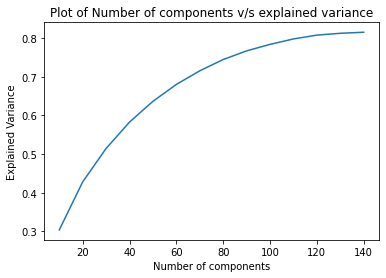

In [27]:
# Program to find the optimal number of components for Truncated SVD
n_comp = range(10,150,10) # list containing different values of components
variance_sum = [] # explained variance ratio for each component of Truncated SVD

for dim in n_comp:
    svd = TruncatedSVD(n_components=dim)
    svd.fit(co_matrix)
    variance_sum.append(svd.explained_variance_ratio_.sum())
    print("Number of components = %r and explained variance = %r"%(dim,svd.explained_variance_ratio_.sum()))
    
plt.plot(n_comp, variance_sum)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

In [33]:
# choose 140 as final dimension to reduce to 
# 利用上述找到的最適合dimension來對co-occurrence matrix進行降維
U, S, V = np.linalg.svd(co_matrix)


In [39]:
re_co_matrix = U[:, 0:140]

In [37]:
A2 = U[:, :140] @ np.diag(S[:140]) @ V[:140,:]
print(A2.round(2))
print(ppmi_matrix)

[[ 1. -0.  0. ...  0.  0.  0.]
 [-0.  1. -0. ...  0.  0.  0.]
 [ 0. -0.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
[[ 3.2672539  0.         0.        ...  0.         0.         0.       ]
 [ 0.         8.051888   0.        ...  0.         0.         0.       ]
 [ 0.         0.         3.5560336 ...  0.         0.         0.       ]
 ...
 [ 0.         0.         0.        ... 12.051888   0.         0.       ]
 [ 0.         0.         0.        ...  0.        12.051888   0.       ]
 [ 0.         0.         0.        ...  0.         0.        12.051888 ]]


### 使用KNN模型進行分類
在進行分類之前，先利用簡單的詞向量平均來計算文本向量

[參考文獻](https://medium.com/ai-academy-taiwan/nlp-%E4%B8%8D%E5%90%8C%E8%A9%9E%E5%90%91%E9%87%8F%E5%9C%A8%E6%96%87%E6%9C%AC%E5%88%86%E9%A1%9E%E4%B8%8A%E7%9A%84%E8%A1%A8%E7%8F%BE%E8%88%87%E5%AF%A6%E4%BD%9C-e72a2daecfc)

In [40]:
# get doc vector via take mean of all word vectors inside the corresponding document

def make_doc_vectors(corpus: List[str], word2idx: dict, vocab_list: List) -> List[np.ndarray]:
    
    # vectorizing data 
    # and make document vector by take mean to all word vecto
    doc_vec = []
    empty_doc_list = []
    for i, sms_msg in enumerate(corpus):
        sms_msg = [word2idx[word] for word in sms_msg.split() if word in vocab_list] #tokenize
        if len(sms_msg) > 0:
            sms_msg = np.array([re_co_matrix[ids] for ids in sms_msg]) #vectorize
            doc_vec.append(sms_msg.mean(axis=0))
        else:
            empty_doc_list.append(i)
            print(f"document {i} doesn't contain word in vocab_list")
            print(corpus[i])
            print("\n")
        
    return np.vstack(doc_vec), empty_doc_list

word2idx = vectorizer.vocabulary_
vocab_list = vectorizer.get_feature_names()

doc_vec_train, missing_train_list = make_doc_vectors(x_train, word2idx, vocab_list)
print("="*50)
doc_vec_test, missing_test_list = make_doc_vectors(x_test, word2idx, vocab_list)

o for apps class


document 3532 doesn't contain word in vocab_list
sorry i ll call later


document 3533 doesn't contain word in vocab_list
good evening how are you


document 3538 doesn't contain word in vocab_list
what happen dear why you silent i am tensed


document 3550 doesn't contain word in vocab_list
i love you both too


document 3551 doesn't contain word in vocab_list
lol u still feeling sick


document 3568 doesn't contain word in vocab_list
she s fine sends her greetings


document 3576 doesn't contain word in vocab_list
yeah confirmed for you staying at that weekend


document 3580 doesn't contain word in vocab_list
ard lor


document 3591 doesn't contain word in vocab_list
i anything lor


document 3592 doesn't contain word in vocab_list
sorry i ll call later


document 3617 doesn't contain word in vocab_list
hey check it da i have listed da


document 3632 doesn't contain word in vocab_list
hui xin is in da lib


document 3660 doesn't contain word in vocab_list
well th

In [47]:
from sklearn.neighbors import KNeighborsClassifier

# training
y_train_filter = np.delete(np.array(y_train), missing_train_list)

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(doc_vec_train, y_train_filter)
train_pred = neigh.predict(doc_vec_train)

# testing
y_test_filter = np.delete(np.array(y_test), missing_test_list)

test_pred = neigh.predict(doc_vec_test)
neigh.score(doc_vec_test, y_test_filter)

0.9281314168377823

In [48]:
print(f"train acc: {np.sum(train_pred == y_train_filter) / len(y_train_filter)}")
print(f"train acc: {np.sum(test_pred == y_test_filter) / len(y_test_filter)}")

train acc: 0.956631366616238
train acc: 0.9281314168377823
